In [1]:
# Standard library imports
import os
import time

# Third-party imports
import imageio
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import torch
import torch.nn as nn
from IPython import display
from IPython.display import clear_output
from scipy.io import loadmat
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Local application/library specific imports
from kan import *
import use_KAN
# from use_KAN import *

from use_training_set import *
import yaml

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# cpu = torch.device('cpu')
# device = cpu
torch.set_default_dtype(torch.float32)

cuda


In [3]:
"""
SOLARIZED HEX     16/8 TERMCOL  XTERM/HEX   L*A*B      RGB         HSB
--------- ------- ---- -------  ----------- ---------- ----------- -----------
base03    #002b36  8/4 brblack  234 #1c1c1c 15 -12 -12   0  43  54 193 100  21
base02    #073642  0/4 black    235 #262626 20 -12 -12   7  54  66 192  90  26
base01    #586e75 10/7 brgreen  240 #585858 45 -07 -07  88 110 117 194  25  46
base00    #657b83 11/7 bryellow 241 #626262 50 -07 -07 101 123 131 195  23  51
base0     #839496 12/6 brblue   244 #808080 60 -06 -03 131 148 150 186  13  59
base1     #93a1a1 14/4 brcyan   245 #8a8a8a 65 -05 -02 147 161 161 180   9  63
base2     #eee8d5  7/7 white    254 #e4e4e4 92 -00  10 238 232 213  44  11  93
base3     #fdf6e3 15/7 brwhite  230 #ffffd7 97  00  10 253 246 227  44  10  99
yellow    #b58900  3/3 yellow   136 #af8700 60  10  65 181 137   0  45 100  71
orange    #cb4b16  9/3 brred    166 #d75f00 50  50  55 203  75  22  18  89  80
red       #dc322f  1/1 red      160 #d70000 50  65  45 220  50  47   1  79  86
magenta   #d33682  5/5 magenta  125 #af005f 50  65 -05 211  54 130 331  74  83
violet    #6c71c4 13/5 brmagenta 61 #5f5faf 50  15 -45 108 113 196 237  45  77
blue      #268bd2  4/4 blue      33 #0087ff 55 -10 -45  38 139 210 205  82  82
cyan      #2aa198  6/6 cyan      37 #00afaf 60 -35 -05  42 161 152 175  74  63
green     #859900  2/2 green     64 #5f8700 60 -20  65 133 153   0  68 100  60
"""
solarized_base03 = "#002b36"
solarized_base02 = "#073642"
solarized_base01 = "#586e75"
solarized_base00 = "#657b83"
solarized_base0 = "#839496"
solarized_base1 = "#93a1a1"
solarized_base2 = "#eee8d5"
solarized_base3 = "#fdf6e3"
solarized_yellow = "#b58900"
solarized_orange = "#cb4b16"
solarized_red = "#dc322f"
solarized_magenta = "#d33682"
solarized_violet = "#6c71c4"
solarized_blue = "#268bd2"
solarized_cyan = "#2aa198"
solarized_green = "#859900"

color_list = [solarized_red, solarized_blue, solarized_cyan, solarized_violet]

## load training sets

In [4]:
config_file = 'setup_ts_full.txt'
x_train, y_train, Q_train = load_training_data(config_file)
parameters_list, SQ_list = load_grid_data(config_file)
x_train_torch = use_KAN.to_torch_device(x_train, device=device)
y_train_torch = use_KAN.to_torch_device(y_train, device=device)

# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(parameters_list[:,0]-parameters[0])<tol
    id_kappa = np.abs(parameters_list[:,1]-parameters[1])<tol
    id_A = np.abs(parameters_list[:,2]-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))


In [5]:
print(np.unique(parameters_list[:,0]))
print(np.unique(parameters_list[:,1]))
print(np.unique(parameters_list[:,2]))

[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


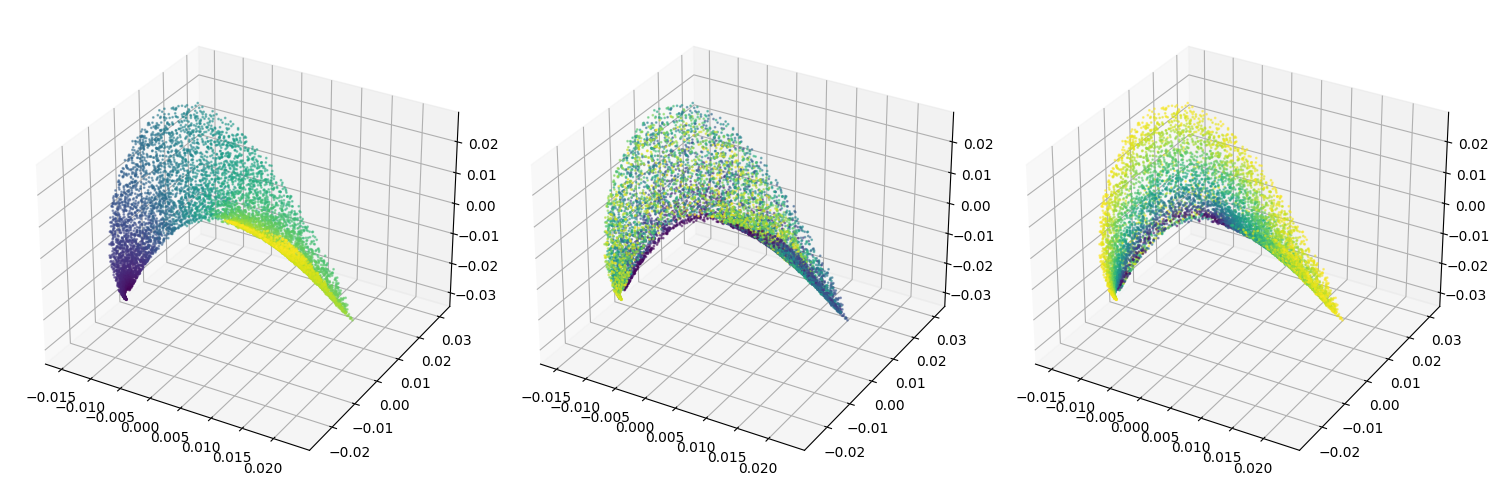

In [6]:
# Perform SVD
y_train_ave = np.mean(y_train, axis=0)
y_train_centered = y_train - y_train_ave
U, S, Vt = np.linalg.svd(y_train_centered, full_matrices=False)

# Get the first 3 principal components
PC = U[:, :3]

# Create a 3D plot
fig = plt.figure(figsize=(15, 5))
colormap = plt.cm.get_cmap('viridis')  # or any other colormap you like

for i in range(3):
    # Create a colormap based on x_train
    colors = colormap((x_train[:,i]-np.min(x_train[:,i]))/(np.max(x_train[:,i])-np.min(x_train[:,i])))

    ax = fig.add_subplot(1,3,i+1, projection='3d')
    ax.scatter(PC[:, 0], PC[:, 1], PC[:, 2], c=colors, s=1, alpha=0.5)

plt.tight_layout()
plt.show()

## load pretrained KAN model

In [7]:
def calculate_output_size(input_size, filter_size, padding, stride):
    return int((input_size - filter_size + 2*padding) / stride + 1)

def to_torch(array):
    return torch.from_numpy(array).float()

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
def to_torch_device(array,device=device):
    return torch.from_numpy(array.astype('float32')).float().to(device)


In [8]:
with open('setup_model_9_7.txt', 'r') as file:
    config = yaml.safe_load(file)
  
use_KAN.update_device(device)  
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)

Device set to: cuda
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [104]:
model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_9_7_sin_full_cq.pth'))

<All keys matched successfully>

In [105]:
def f_SQ_KAN(model, x, Q=Q):
    # Extract phi from x
    phi = x[:, 0]*1
    
    # Transform x using kan_aug
    n_data = x.shape[0]
    x = x.view(-1, 3)
    x_transformed = model.kan_aug(x)
    
    # Transform Q using to_torch_device
    Q_torch = to_torch_device(Q)
    Q_torch_scale = to_torch_device((Q - 6) / 20)
    
    # Expand dimensions to match Q_torch
    x_expanded = x_transformed.unsqueeze(1).expand(-1, Q_torch_scale.size(0), -1)
    Q_expanded = Q_torch_scale.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
    
    # Combine Q and x
    Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
    Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
    
    # Produce G(Q, x) using kan
    G_full = model.kan(Q_params_reshaped)
    G_full_reshaped = G_full.view(x_transformed.size(0), Q_torch_scale.size(0), 3)  # (n_data, n_Q, 3)
    
     # Extract outputs
    output_1 = G_full_reshaped[:, :, 0]
    output_2 = G_full_reshaped[:, :, 1]
    output_3 = G_full_reshaped[:, :, 2]
    
    # Compute G_HS_bias
    G_HS_bias = (model.multiplier * output_1 * torch.sin(output_2)) / Q_torch
    
    # Expand phi to match output_1
    phi_expanded = phi.unsqueeze(1).expand_as(output_1)
    
    # Compute alpha, beta, and gama
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    # Compute G_hs(Q, phi)
    Q_torch = Q_torch.unsqueeze(0).expand(x.size(0), -1)
    alpha_expanded = alpha.unsqueeze(1).expand_as(Q_torch)
    beta_expanded = beta.unsqueeze(1).expand_as(Q_torch)
    gama_expanded = gama.unsqueeze(1).expand_as(Q_torch)
    
    G_hs = (alpha_expanded * (torch.sin(Q_torch) - Q_torch * torch.cos(Q_torch)) / Q_torch**2 +
            beta_expanded * (2 * Q_torch * torch.sin(Q_torch) + (2 - Q_torch**2) * torch.cos(Q_torch) - 2) / Q_torch**3 +
            gama_expanded * (-Q_torch**4 * torch.cos(Q_torch) + 4 * ((3 * Q_torch**2 - 6) * torch.cos(Q_torch) +
            (Q_torch**3 - 6 * Q_torch) * torch.sin(Q_torch) + 6)) / Q_torch**5)
    
    # Ensure G_hs has the shape (n_sample, n_Q)
    G_hs = G_hs.view(x.size(0), Q_torch.size(1))
    
    S_hs = 1 / (24 * phi_expanded * (G_hs + G_HS_bias) / Q_torch + 1 + output_3)
    
    return S_hs

def err_L2(x,y):
    index_loss = np.random.randint(95, size=76)
    return np.mean((x[index_loss]-y[index_loss])**2)

In [106]:
def G_hs_np(phi, Q):
    """
    Compute G_hs given phi and Q using NumPy.

    Parameters:
    phi (float): A scalar representing the phi value.
    Q (np.ndarray): A 1D array of shape (n_Q,) representing the Q values.

    Returns:
    np.ndarray: A 1D array of shape (n_Q,) representing the computed G_hs values.
    """
    # Compute alpha, beta, and gama
    one_minus_phi = 1 - phi
    one_minus_phi_pow4 = one_minus_phi**4
    one_plus_2phi = 1 + 2 * phi
    one_plus_phi_div2 = 1 + phi / 2

    alpha = (one_plus_2phi**2) / one_minus_phi_pow4
    beta = -6 * phi * (one_plus_phi_div2**2) / one_minus_phi_pow4
    gama = phi * alpha / 2

    # Compute G_hs(Q, phi)
    sin_Q = np.sin(Q)
    cos_Q = np.cos(Q)
    Q_pow2 = Q**2
    Q_pow3 = Q**3
    Q_pow4 = Q**4
    Q_pow5 = Q**5

    term1 = alpha * (sin_Q - Q * cos_Q) / Q_pow2
    term2 = beta * (2 * Q * sin_Q + (2 - Q_pow2) * cos_Q - 2) / Q_pow3
    term3 = gama * (-Q_pow4 * cos_Q + 4 * ((3 * Q_pow2 - 6) * cos_Q + (Q_pow3 - 6 * Q) * sin_Q + 6)) / Q_pow5

    G_hs = term1 + term2 + term3

    return G_hs

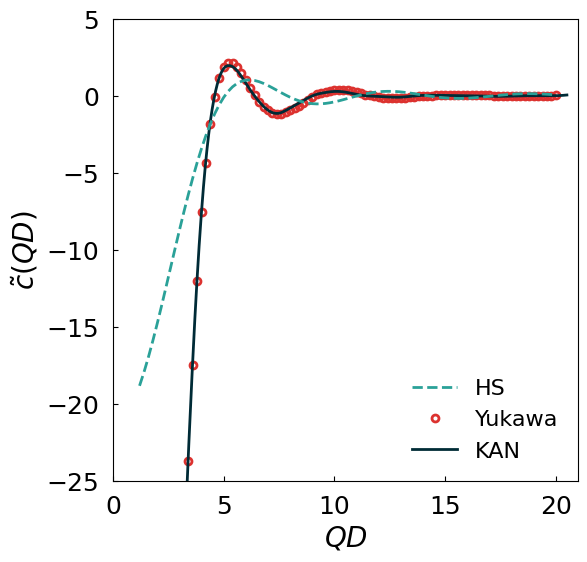

In [115]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
q_fine = np.linspace(1.05,20.5,1000)

for A in [10]:
    params = np.array([0.225,0.3,A])
    index = id_params(params)
    params_index = parameters_list[index]
    x_index = params_index
    x_index[:,2] = np.log(x_index[:,2])

    sq_GT = SQ_list[index,:].T
    sq_KAN = f_SQ_KAN(model_KAN, to_torch_device(x_index, device=device), q_fine).detach().cpu().numpy().T

    G_gt = ((1/sq_GT-1)/24/params[0])[:,0]*Q_train
    G_KAN = ((1/sq_KAN-1)/24/params[0])[:,0]*q_fine
    G_hs = G_hs_np(params[0], Q_train)

    C_gt = -G_gt*24/Q_train
    C_KAN = -G_KAN*24/q_fine
    C_hs = -G_hs*24/Q_train

    ax.plot(Q_train,C_hs, '--', label='HS', lw=2, color=solarized_cyan, zorder=3)
    ax.plot(Q_train,C_gt, '.', label='Yukawa', lw=2, color=solarized_red, fillstyle='none', markeredgewidth=2, markersize=10)
    ax.plot(q_fine,C_KAN, '-', label='KAN', lw=2, color=solarized_base03)

ax.set_ylim([-25,5])
# ax.set_yticks([-15,-10,-5,0,5])
# ax.set_yscale('log')
ax.set_xlim([0,21])
# ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$\tilde{c}(QD)$',fontsize=20)
ax.legend(frameon=False,fontsize=16)    

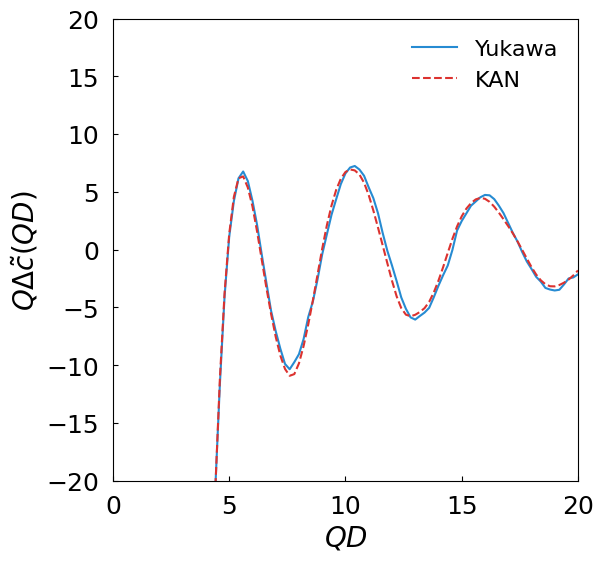

In [108]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()


for A in [10]:
    params = np.array([0.3,0.3,A])
    index = id_params(params)
    params_index = parameters_list[index]
    Q_random = np.sort(np.random.rand(250)*20)
    x_index = params_index
    x_index[:,2] = np.log(x_index[:,2])

    sq_GT = SQ_list[index,:].T
    sq_KAN = f_SQ_KAN(model_KAN, to_torch_device(x_index, device=device), Q_train).detach().cpu().numpy().T

    G_gt = ((1/sq_GT-1)/24/params[0])[:,0]*Q_train
    G_KAN = ((1/sq_KAN-1)/24/params[0])[:,0]*Q_train
    G_hs = G_hs_np(params[0], Q_train)

    C_gt = -G_gt*24/Q_train
    C_KAN = -G_KAN*24/Q_train
    C_hs = -G_hs*24/Q_train

    # ax.plot(Q_train,C_hs, '-k', label='HS')
    ax.plot(Q_train,(C_gt-C_hs)*Q_train, '-', label='Yukawa', color=solarized_blue)
    ax.plot(Q_train,(C_KAN-C_hs)*Q_train, '--', label='KAN', color=solarized_red)
# ax.plot(Q_train,(G_gt-G_hs), label=r'$\Delta G(Q)$')
ax.set_ylim([-20,20])
# ax.set_yscale('log')
ax.set_xlim([0,20])
# ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$Q\Delta\tilde{c}(QD)$',fontsize=20)
ax.legend(frameon=False,fontsize=16)    

[0.045, 0.3, 10]
[0.135, 0.3, 10]
[0.225, 0.3, 10]
[0.315, 0.3, 10]
[0.405, 0.3, 10]


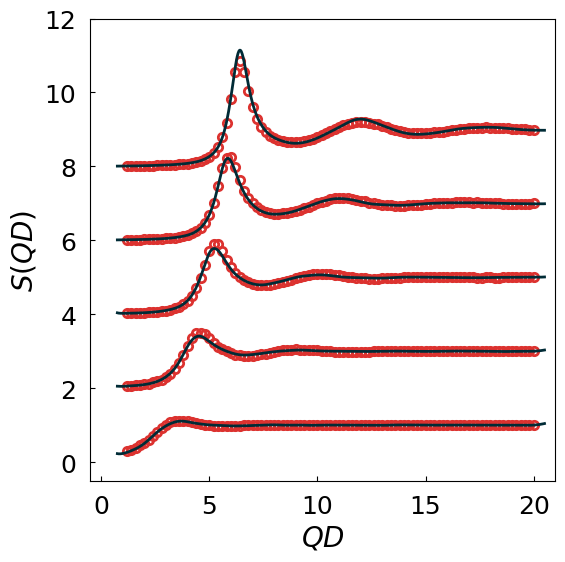

In [96]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
q_fine = np.linspace(0.75,20.5,1000)


for i in range(5):
    params = [np.unique(parameters_list[:,0])[i*6+2],0.3,10]
    print(params)
    index = id_params(params)
    color = plt.cm.viridis(i / 8)
    x_index = parameters_list[index]
    x_index[:,2] = np.log(x_index[:,2])
    sq_GT = SQ_list[index,:].T
    sq_KAN = f_SQ_KAN(model_KAN, to_torch_device(x_index, device=device), q_fine).detach().cpu().numpy()
    
    ax.plot(Q_train,sq_GT+2*i, '.', color=solarized_red, lw=2, fillstyle='none', markeredgewidth=2, markersize=12)
    ax.plot(q_fine, sq_KAN[0,:]+2*i,"-", color=solarized_base03, lw=2)
    
ax.set_xlabel(r'$QD$', fontsize=20)
ax.set_ylabel(r'$S(QD)$', fontsize=20)
ax.set_xlim([-0.5,21])
ax.set_ylim([-0.5,12])
ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)